In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option("display.max_columns", None)
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
data = pd.read_csv("learn.csv")

In [3]:
data.loanapply_insert_time = pd.to_datetime(data.loanapply_insert_time)
data.insert_time = pd.to_datetime(data.insert_time)
data.company_enter_month = pd.to_datetime(data.company_enter_month)
data.birth_year = pd.to_datetime(data.birth_year)

In [4]:
del data["Unnamed: 0"]
x = data.copy()

In [5]:
x.loan_limit = np.log10(x.loan_limit + 1)
x.desired_amount = np.log10(x.desired_amount+1)
x.yearly_income = np.log10(x.yearly_income+1)
x.existing_loan_amt = np.log10(x.existing_loan_amt + 1)

In [6]:
c1 = pd.get_dummies(x.income_type)
c2 = pd.get_dummies(x.employment_type)
c2.rename(columns = {"기타":"기타_직업"}, inplace = True)
c3 = pd.get_dummies(x.houseown_type)
c4 = pd.get_dummies(x.purpose)
c4.rename(columns = {"기타": "기타_목적"}, inplace = True)

In [7]:
c = pd.concat([c1, c2, c3, c4], axis = 1)

In [8]:
x.drop(["income_type", "employment_type", "houseown_type", "purpose"], inplace = True, axis= 1)
x = pd.concat([x, c], axis = 1)

In [9]:
X_train = x[x['insert_time']<'2022-05-16']
X_test = x[x['insert_time']>= '2022-05-16']

In [10]:
Y_train = X_train['is_applied']
Y_test = X_test['is_applied']
del X_train['is_applied']
del X_test['is_applied']

In [11]:
from catboost import CatBoostClassifier 

In [12]:
model = CatBoostClassifier(iterations=2,
                           depth=5,
                           learning_rate=1,
                           loss_function='Logloss',
                           verbose=True)

In [13]:
model.fit(X_train, Y_train)

0:	learn: 0.1852638	total: 885ms	remaining: 885ms
1:	learn: 0.1798325	total: 1.57s	remaining: 0us


In [14]:
p = model.predict_proba(X_test)[:, 1]

In [15]:
f1_score(Y_test, p > 0.054)

0.21698942077580977

In [16]:
new = data.copy()

In [9]:
new = x.copy()

In [10]:
new.drop(["application_id", "loanapply_insert_time", "bank_id", 
          "product_id", "loan_limit", "loan_rate", "is_applied"],
        inplace = True, axis = 1)

In [11]:
new = new.drop_duplicates(subset = 'user_id', keep = 'last')

In [12]:
indices = ["gender","credit_score", "yearly_income", 
           "desired_amount", "personal_rehabilitation_yn",
           'personal_rehabilitation_complete_yn',
       'existing_loan_cnt', 'existing_loan_amt']

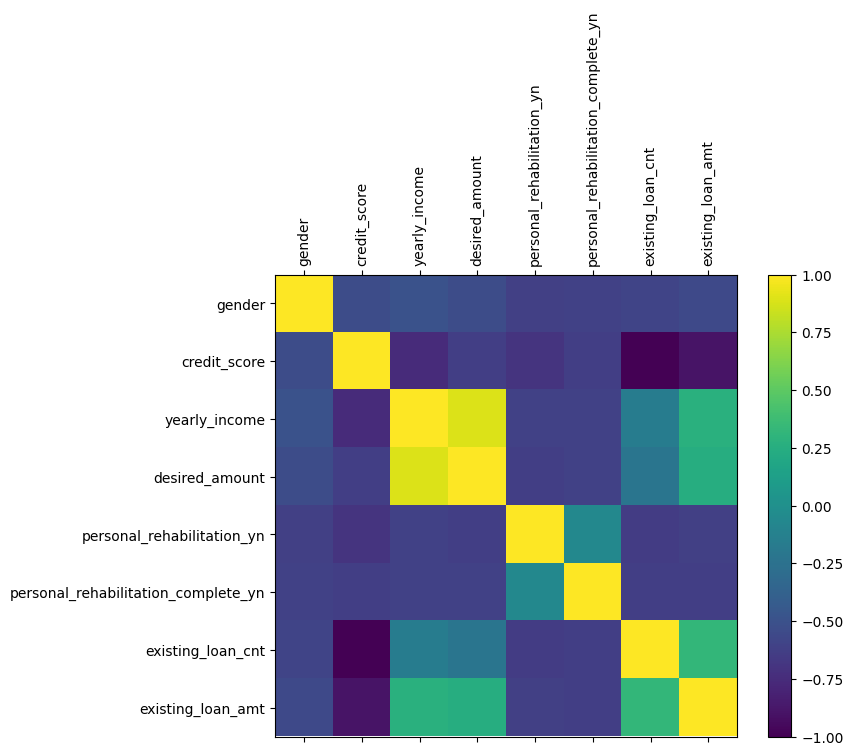

In [21]:
corr = new[indices].corr()
fig, ax = plt.subplots(figsize=(8, 6))
cax=ax.matshow(corr,vmin=-1,vmax=1)
ax.matshow(corr)
plt.xticks(range(len(corr.columns)), corr.columns)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.xticks(rotation=90)
plt.colorbar(cax)

In [22]:
from sklearn import mixture

In [23]:
def plot_BIC(matrix,x_calls,K):
    from sklearn import mixture
    BIC=[]
    for k in K:
        model=mixture.GaussianMixture(n_components=k,init_params='kmeans')
        model.fit(matrix[x_calls])
        BIC.append(model.bic(matrix[x_calls]))
    fig, ax = plt.subplots(figsize=(8, 6))
    plt.plot(K,BIC,'-cx')
    plt.ylabel("BIC score")
    plt.xlabel("k")
    plt.title("BIC scoring for K-means cell's behaviour")
    print(K)
    return(BIC)

range(8, 12)


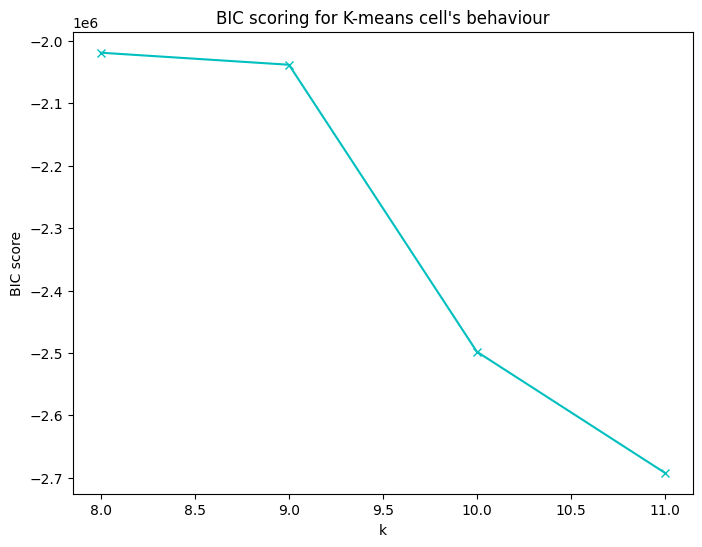

In [24]:
K = range(8, 12)
BIC = plot_BIC(new, indices,K)

In [25]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
cluster = KMeans(n_clusters=10,random_state=217)
new['cluster'] = cluster.fit_predict(new[indices])
print(new.cluster.value_counts())

2    53761
9    39904
0    35522
3    31928
5    30958
8    20718
6    20120
1    19256
4     6407
7      747
Name: cluster, dtype: int64


In [26]:
pca = PCA(n_components=3)
new['x'] = pca.fit_transform(new[indices])[:,0]
new['y'] = pca.fit_transform(new[indices])[:,1]
new['z'] = pca.fit_transform(new[indices])[:,2]

In [27]:
cluster_centers = pca.transform(cluster.cluster_centers_)
cluster_centers = pd.DataFrame(cluster_centers, columns=['x', 'y', 'z'])
cluster_centers['cluster'] = range(0, len(cluster_centers))
print(cluster_centers)

            x         y         z  cluster
0    6.011837 -0.088030 -0.101891        0
1 -196.062261 -0.152417  0.001601        1
2   93.498257  0.371953  0.194291        2
3  -52.625636 -0.395847 -0.115348        3
4  206.711373 -0.990075 -0.542722        4
5  142.724779  0.175094  0.072750        5
6 -266.664693  0.232898 -0.066546        6
7  534.188566 -6.345263 -2.787518        7
8 -124.101887 -0.372314 -0.001044        8
9   50.371345  0.185305  0.037438        9


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


Text(0.5, 1.0, 'Data Segmentation')

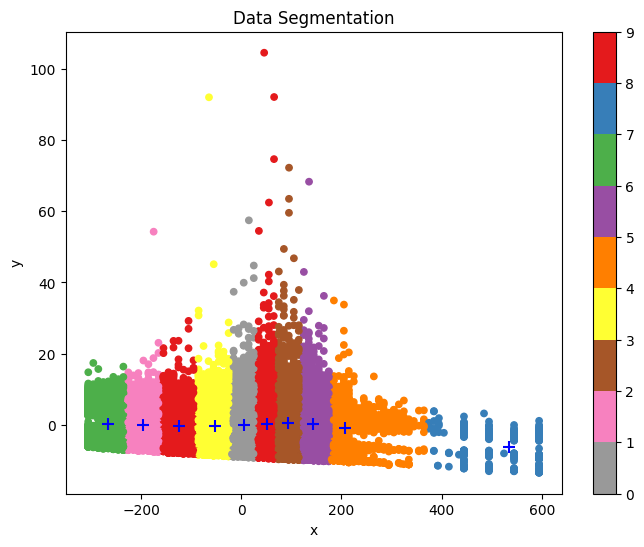

In [28]:
fig, ax = plt.subplots(figsize=(8, 6))
scatter=ax.scatter(new['x'],new['y'],c=new['cluster'],s=21,cmap=plt.cm.Set1_r)
ax.scatter(cluster_centers['x'],cluster_centers['y'],s=70,c='blue',marker='+')
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.colorbar(scatter)
plt.title('Data Segmentation')

Text(0.5, 0.92, 'Data Segmentation')

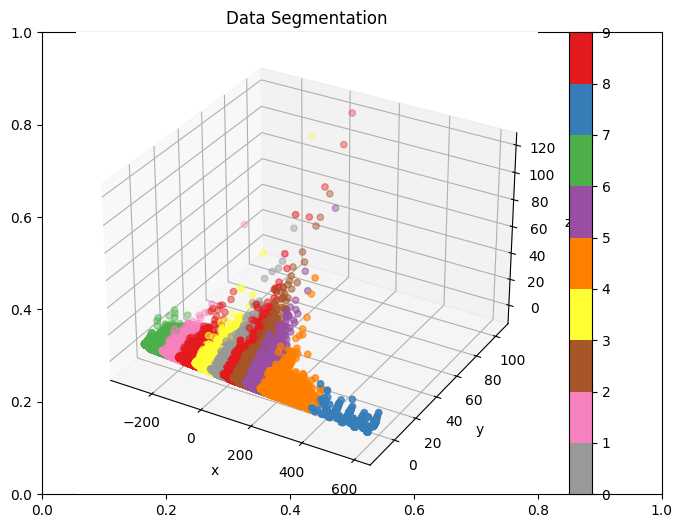

In [29]:
fig, ax = plt.subplots(figsize=(8, 6))
ax=fig.add_subplot(111, projection='3d')
scatter=ax.scatter(new['x'],new['y'],new['z'],c=new['cluster'],s=21,cmap=plt.cm.Set1_r)
ax.scatter(cluster_centers['x'],cluster_centers['y'],cluster_centers['z'],s=70,c='red',marker='+')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.colorbar(scatter)
plt.title('Data Segmentation')

In [5]:
hello = data.copy()

In [6]:
by_app = hello.groupby("application_id").max()

In [7]:
by_app.reset_index(drop = "True", inplace = True)

In [8]:
by_user = by_app.groupby("user_id").mean()

In [9]:
by_user

,bank_id,product_id,loan_limit,loan_rate,is_applied,gender,credit_score,yearly_income,desired_amount,personal_rehabilitation_yn,personal_rehabilitation_complete_yn,existing_loan_cnt,existing_loan_amt
user_id,,,,,,,,,,,,,
9,59.000000,268.0,51000000.0,20.000000,0.000000,1.0,810.0,29000000.0,1.500000e+07,0.0,0.0,1.0,0.0
11,61.000000,265.0,45000000.0,19.950000,1.000000,1.0,655.0,25000000.0,7.500000e+06,0.0,0.0,1.0,14000000.0
14,37.000000,206.0,27000000.0,19.900000,0.000000,0.0,603.0,27.0,3.000000e+01,0.0,0.0,0.0,0.0
17,23.500000,177.5,29000000.0,18.900000,1.000000,1.0,540.0,50000000.0,6.500000e+06,0.0,0.0,0.0,0.0
19,35.000000,192.0,5000000.0,13.800000,0.000000,0.0,670.0,0.0,2.000000e+01,0.0,0.0,7.0,34.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
879692,60.200000,265.0,45200000.0,18.500000,1.000000,1.0,790.0,44000000.0,2.540000e+07,0.0,0.0,3.0,21000000.0
879693,46.333333,224.0,19000000.0,19.533333,0.666667,0.0,710.0,24000000.0,3.666667e+06,0.0,0.0,3.0,16000000.0
879695,44.000000,223.0,17000000.0,17.700000,1.000000,1.0,620.0,30.0,1.500000e+01,0.0,0.0,0.0,0.0


In [10]:
ox = by_user[["is_applied", "credit_score", "yearly_income", "desired_amount"]]

In [11]:
ox

,is_applied,credit_score,yearly_income,desired_amount
user_id,,,,
9,0.000000,810.0,29000000.0,1.500000e+07
11,1.000000,655.0,25000000.0,7.500000e+06
14,0.000000,603.0,27.0,3.000000e+01
17,1.000000,540.0,50000000.0,6.500000e+06
19,0.000000,670.0,0.0,2.000000e+01
...,...,...,...,...
879692,1.000000,790.0,44000000.0,2.540000e+07
879693,0.666667,710.0,24000000.0,3.666667e+06
879695,1.000000,620.0,30.0,1.500000e+01


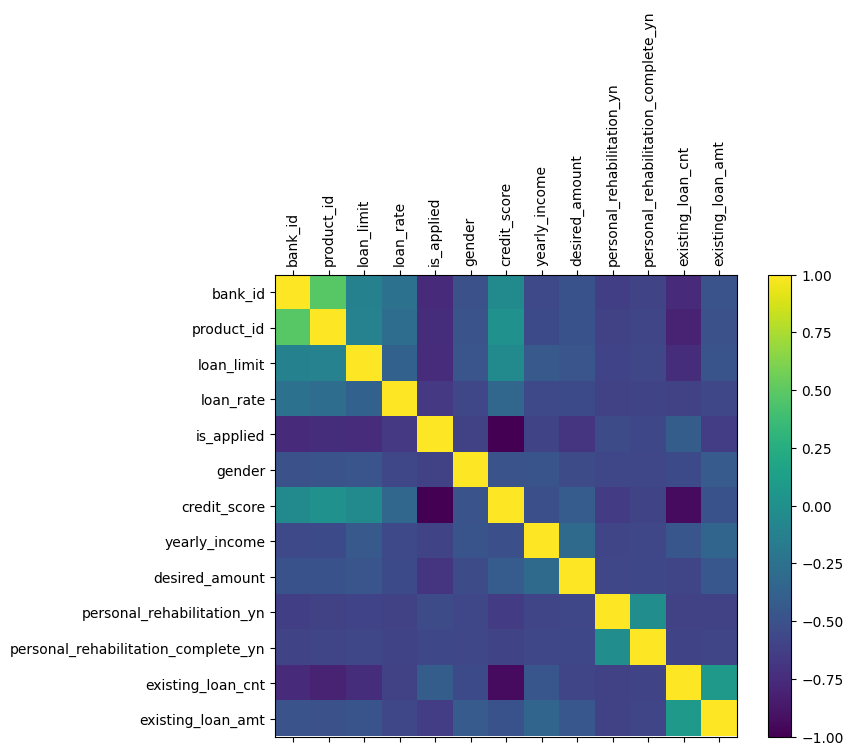

In [13]:
corr = by_user[by_user.columns].corr()
fig, ax = plt.subplots(figsize=(8, 6))
cax=ax.matshow(corr,vmin=-1,vmax=1)
ax.matshow(corr)
plt.xticks(range(len(corr.columns)), corr.columns)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.xticks(rotation=90)
plt.colorbar(cax)

range(5, 8)


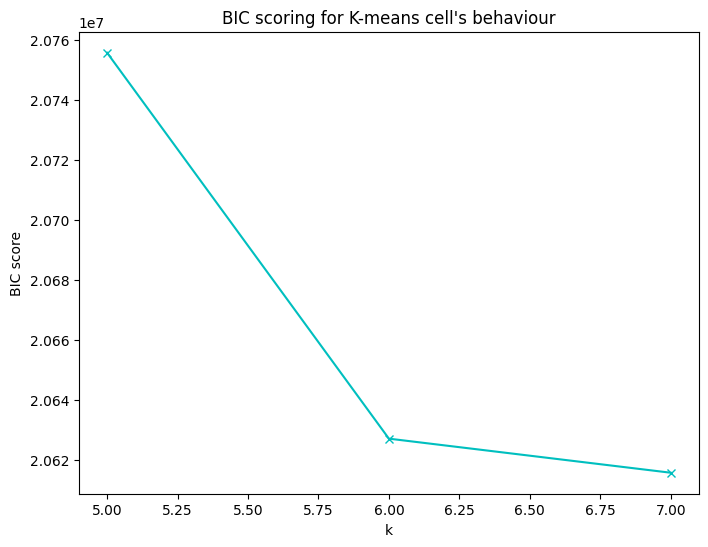

In [50]:
K = range(5, 9)
BIC = plot_BIC(ox, ["is_applied", "credit_score", "yearly_income", "desired_amount"],K)

In [58]:
cluesterr = KMeans(n_clusters = 7, random_state = 217)
ox['cluster'] = cluesterr.fit_predict(ox[["is_applied", "credit_score", "yearly_income", "desired_amount"]])
print(ox.cluster.value_counts())

0    252968
3      5676
1       276
4       245
5        79
6        39
2        38
Name: cluster, dtype: int64


/var/folders/mj/jcmvk9nd451b_mnylnj74qrm0000gn/T/ipykernel_41228/3581150369.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ox['cluster'] = cluesterr.fit_predict(ox[["is_applied", "credit_score", "yearly_income", "desired_amount"]])


In [60]:
pca = PCA(n_components=2)
ox['x'] = pca.fit_transform(ox[["is_applied", "credit_score", "yearly_income", "desired_amount"]])[:,0]
ox['y'] = pca.fit_transform(ox[["is_applied", "credit_score", "yearly_income", "desired_amount"]])[:,1]

/var/folders/mj/jcmvk9nd451b_mnylnj74qrm0000gn/T/ipykernel_41228/3820332388.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ox['x'] = pca.fit_transform(ox[["is_applied", "credit_score", "yearly_income", "desired_amount"]])[:,0]
/var/folders/mj/jcmvk9nd451b_mnylnj74qrm0000gn/T/ipykernel_41228/3820332388.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ox['y'] = pca.fit_transform(ox[["is_applied", "credit_score", "yearly_income", "desired_amount"]])[:,1]


In [61]:
cluster_centers = pca.transform(cluesterr.cluster_centers_)
cluster_centers = pd.DataFrame(cluster_centers, columns=['x', 'y'])
cluster_centers['cluster'] = range(0, len(cluster_centers))
print(cluster_centers)

              x             y  cluster
0 -1.299188e+07 -1.518824e+06        0
1  2.239063e+09 -8.699164e+07        1
2  9.484316e+09 -5.912964e+08        2
3  3.187056e+08 -3.576612e+06        3
4  2.712273e+08  1.134172e+09        4
5  5.127700e+09 -1.807475e+08        5
6  6.915465e+08  4.805249e+09        6


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


Text(0.5, 1.0, 'Data Segmentation')

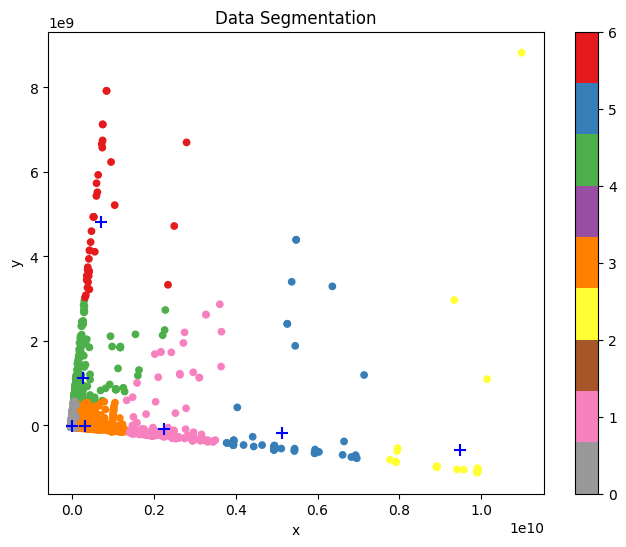

In [62]:
fig, ax = plt.subplots(figsize=(8, 6))
scatter=ax.scatter(ox['x'],ox['y'],c=ox['cluster'],s=21,cmap=plt.cm.Set1_r)
ax.scatter(cluster_centers['x'],cluster_centers['y'],s=70,c='blue',marker='+')
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.colorbar(scatter)
plt.title('Data Segmentation')